In [2]:
import torch
import pandas as pd
from tqdm import tqdm

In [12]:

df = pd.read_csv(
    'dataset/jon-snow-tweets_training-validation_set_sentiment.csv')

In [13]:
df.head()

,text,sentiment,polarity,subjectivity,Preprocess
0,@IsabelOakeshott @jonsnowC4 He stated a fact.,Neu,0.00,0.000,isabeloakeshott jonsnowc4 he stated fact
1,@prwhittle How isn't @jonsnowC4 being racist t...,Neu,0.00,0.000,prwhittle how isn jonsnowc4 being racist there...
2,@JDShuttlesworth @jonsnowC4 @CashApp A ski slo...,Neu,0.00,0.000,jdshuttlesworth jonsnowc4 cashapp ski slope in...
3,Get the fuck outta my face! before I opened it...,Neg,-0.45,0.600,get the fuck outta my face before opened it th...
4,@tinabobuk I was there too. Never saw so many ...,Pos,0.65,0.625,tinabobuk wa there too never saw so many brexi...


In [14]:
df.sentiment.value_counts()

Neu    2333
Pos    1630
Neg    1037
Name: sentiment, dtype: int64

In [15]:
label_dict = {l:i for i,l in enumerate(df.sentiment.unique())}
num2label = {v:k for k, v in label_dict.items()}

In [16]:
num2label

{0: 'Neu', 1: 'Neg', 2: 'Pos'}

In [17]:

label_dict

{'Neu': 0, 'Neg': 1, 'Pos': 2}

In [18]:
df['label'] = df.sentiment.replace(label_dict)
df.head()

,text,sentiment,polarity,subjectivity,Preprocess,label
0,@IsabelOakeshott @jonsnowC4 He stated a fact.,Neu,0.00,0.000,isabeloakeshott jonsnowc4 he stated fact,0
1,@prwhittle How isn't @jonsnowC4 being racist t...,Neu,0.00,0.000,prwhittle how isn jonsnowc4 being racist there...,0
2,@JDShuttlesworth @jonsnowC4 @CashApp A ski slo...,Neu,0.00,0.000,jdshuttlesworth jonsnowc4 cashapp ski slope in...,0
3,Get the fuck outta my face! before I opened it...,Neg,-0.45,0.600,get the fuck outta my face before opened it th...,1
4,@tinabobuk I was there too. Never saw so many ...,Pos,0.65,0.625,tinabobuk wa there too never saw so many brexi...,2


In [19]:
from sklearn.model_selection import train_test_split

In [10]:
SEED = 42069

In [11]:

Xt, Xv, yt, yv = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=SEED,
    stratify=df.label.values
)

In [12]:
df['type'] = ['tmp'] * df.shape[0]

In [13]:
df.head()


,text,sentiment,polarity,subjectivity,Preprocess,label,type
0,I’ve selected Arya Stark to sit on the Iron Th...,Neg,-0.25,0.600000,i ve selected arya stark to sit on the iron th...,0,tmp
1,#got #gameofthrones #arya #season7 #season8 #f...,Pos,0.50,0.600000,got gameofthrones arya season7 season8 funkopo...,1,tmp
2,"Arya stark, she sure say she no bi related to ...",Pos,0.06,0.437778,arya stark she sure say she no bi related to o...,1,tmp
3,I’ve selected Arya Stark to sit on the Iron Th...,Neg,-0.25,0.600000,i ve selected arya stark to sit on the iron th...,0,tmp
4,@QuestionMan18 @thereseverdun @Flickalilla @Te...,Neu,0.00,0.000000,questionman18 thereseverdun flickalilla tellev...,2,tmp


In [14]:
df.loc[Xt, 'type'] = 'train'
df.loc[Xv, 'type'] = 'val'

In [15]:
df.groupby(['sentiment', 'label', 'type']).count()

text  polarity  subjectivity  Preprocess
sentiment label type                                           
Neg       0     train  2536      2536          2536        2536
                val     447       447           447         447
Neu       2     train  1380      1380          1380        1380
                val     244       244           244         244
Pos       1     train   334       334           334         334
                val      59        59            59          59

In [16]:

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [17]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [18]:

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\users\lahir\appdata\local\programs\python\python38\lib\site-packages\transformers\tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.type=='train'].label.values)


In [20]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.type=='val'].label.values)

In [21]:
train_ds = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_ds = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [22]:
print(len(train_ds), len(val_ds))

4250 750


In [23]:
from transformers import BertForSequenceClassification

In [24]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [26]:
BATCH_SIZE = 32
EPOCHS = 4

In [27]:
train_dl = DataLoader(
    train_ds,
    sampler=RandomSampler(train_ds),
    batch_size=BATCH_SIZE
)

val_dl = DataLoader(
    val_ds,
    sampler=RandomSampler(val_ds),
    batch_size=BATCH_SIZE
)

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [29]:
optim = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

In [31]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [32]:
# Defining Performance Metrics
import numpy as np
from sklearn.metrics import f1_score

In [33]:

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [34]:
def print_acc_per_class(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        total_true = preds_flat[labels_flat == label]
        true_positives = total_true[total_true == label]
        print(f'Class: {num2label[label]}')
        print(f'Accuracy: {len(true_positives)}/{len(total_true)}')

In [35]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
import random

In [41]:
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [47]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dl):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dl), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        
        inputs = {
            'input_ids': b_input_ids,
            'attention_mask': b_input_mask,
            'labels': b_labels
        }

#         loss, logits = model(b_input_ids, 
#                              token_type_ids=None, 
#                              attention_mask=b_input_mask, 
#                              labels=b_labels)
        
        outputs = model(**inputs)
        loss = outputs[0]
#         training_loss += loss.item()
#         loss.backward()

#         logits = logits.detach().cpu().numpy()
#         label_ids = inputs['labels'].cpu().numpy()
#         predictions.append(logits)
#         true_vals.append(label_ids)

#         logits = logits.detach().cpu().numpy()
#         label_ids = inputs['labels'].cpu().numpy()
#         predictions.append(logits)
#         true_vals.append(label_ids)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optim.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dl)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    predictions, true_vals = [], []

    # Evaluate data for one epoch
    for batch in val_dl:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        inputs = {
            'input_ids': b_input_ids,
            'attention_mask': b_input_mask,
            'labels': b_labels
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        
#         with torch.no_grad():        

#             # Forward pass, calculate logit predictions.
#             # token_type_ids is the same as the "segment ids", which 
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             # The documentation for this `model` function is here: 
#             # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#             # Get the "logits" output by the model. The "logits" are the output
#             # values prior to applying an activation function like the softmax.
#             (loss, logits) = model(b_input_ids, 
#                                    token_type_ids=None, 
#                                    attention_mask=b_input_mask,
#                                    labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        
        predictions.append(logits)
        true_vals.append(label_ids)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dl)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dl)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    133.    Elapsed: 0:29:40.
  Batch    80  of    133.    Elapsed: 0:59:59.
  Batch   120  of    133.    Elapsed: 1:30:03.

  Average training loss: 0.28
  Training epcoh took: 1:39:45

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.25
  Validation took: 0:06:17

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    133.    Elapsed: 0:30:36.
  Batch    80  of    133.    Elapsed: 1:01:26.
  Batch   120  of    133.    Elapsed: 1:31:14.

  Average training loss: 0.20
  Training epcoh took: 1:40:42

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.21
  Validation took: 0:06:07

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    133.    Elapsed: 0:29:50.
  Batch    80  of    133.    Elapsed: 0:59:13.
  Batch   120  of    133.    Elapsed: 1:28:01.

  Average training loss: 0.16
  Training epcoh took: 1:37:15

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.22
  Validation too

In [48]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.28,0.25,0.92,1:39:45,0:06:17
2,0.20,0.21,0.93,1:40:42,0:06:07
3,0.16,0.22,0.93,1:37:15,0:06:09
4,0.14,0.22,0.93,1:36:53,0:06:15


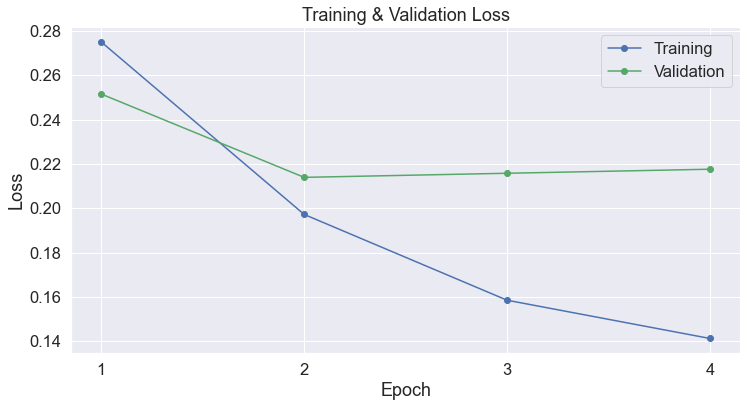

In [50]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [51]:
test_df = pd.read_csv(
    'dataset/arya_stark_tweets_test_set_sentiment.csv')

In [52]:
test_df.head()

,text,sentiment,polarity,subjectivity,Preprocess
0,@AryaStark_got_ Men duuuu🤩🤩🤩\n😍😍😍😍😍😍😍,Neu,0.00,0.00,aryastark_got_ men duuuu
1,"@munkhchuluun_s Хмм, бас л олон нүүртэй хүн юм...",Neg,-0.20,0.60,munkhchuluun_s хмм бас л олон нүүртэй хүн юмаа...
2,@aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه ر...,Neu,0.00,0.00,aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه رف...
3,@ElGodUsopp Quien es tu fav de juego de tronos...,Neg,-0.20,0.60,elgodusopp quien e tu fav de juego de tronos l...
4,@starksdany @dnarrysdragons She's not...Arya S...,Pos,0.15,0.55,starksdany dnarrysdragons she not arya stark t...


In [53]:
test_df.sentiment.value_counts()

Neu    3319
Neg    1188
Pos     493
Name: sentiment, dtype: int64

In [54]:
label_dict = {l:i for i,l in enumerate(df.sentiment.unique())}
num2label = {v:k for k, v in label_dict.items()}

In [55]:
num2label
label_dict

{'Neg': 0, 'Pos': 1, 'Neu': 2}

In [56]:
test_df['label'] = df.sentiment.replace(label_dict)
test_df.head()

,text,sentiment,polarity,subjectivity,Preprocess,label
0,@AryaStark_got_ Men duuuu🤩🤩🤩\n😍😍😍😍😍😍😍,Neu,0.00,0.00,aryastark_got_ men duuuu,0
1,"@munkhchuluun_s Хмм, бас л олон нүүртэй хүн юм...",Neg,-0.20,0.60,munkhchuluun_s хмм бас л олон нүүртэй хүн юмаа...,1
2,@aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه ر...,Neu,0.00,0.00,aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه رف...,1
3,@ElGodUsopp Quien es tu fav de juego de tronos...,Neg,-0.20,0.60,elgodusopp quien e tu fav de juego de tronos l...,0
4,@starksdany @dnarrysdragons She's not...Arya S...,Pos,0.15,0.55,starksdany dnarrysdragons she not arya stark t...,2


In [58]:
test_df['type'] = ['test'] * test_df.shape[0]
test_df.head()

,text,sentiment,polarity,subjectivity,Preprocess,label,type
0,@AryaStark_got_ Men duuuu🤩🤩🤩\n😍😍😍😍😍😍😍,Neu,0.00,0.00,aryastark_got_ men duuuu,0,test
1,"@munkhchuluun_s Хмм, бас л олон нүүртэй хүн юм...",Neg,-0.20,0.60,munkhchuluun_s хмм бас л олон нүүртэй хүн юмаа...,1,test
2,@aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه ر...,Neu,0.00,0.00,aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه رف...,1,test
3,@ElGodUsopp Quien es tu fav de juego de tronos...,Neg,-0.20,0.60,elgodusopp quien e tu fav de juego de tronos l...,0,test
4,@starksdany @dnarrysdragons She's not...Arya S...,Pos,0.15,0.55,starksdany dnarrysdragons she not arya stark t...,2,test


In [59]:
test_df.groupby(['sentiment', 'label', 'type']).count()

text  polarity  subjectivity  Preprocess
sentiment label type                                          
Neg       0     test   708       708           708         708
          1     test    95        95            95          95
          2     test   385       385           385         385
Neu       0     test  1983      1983          1983        1983
          1     test   252       252           252         252
          2     test  1084      1084          1084        1084
Pos       0     test   292       292           292         292
          1     test    46        46            46          46
          2     test   155       155           155         155

In [60]:
sentences = test_df.text.values
labels = test_df.label.values

In [61]:
sentences

array(['@AryaStark_got_ Men duuuu🤩🤩🤩\n😍😍😍😍😍😍😍',
       '@munkhchuluun_s Хмм, бас л олон нүүртэй хүн юмаа арай2\n#Arya Stark хажууд нь зарчимтай хүн юм байна, хөөрхий https://t.co/WbDpVd9l4l',
       '@aryastark_8 ظرفیت گلاب آدینه رو نداشته دیگه رفته دنبال لیاقتش',
       ...,
       '@AryaStark_got_ Det blir inte bättre än så. Ha en mysig kväll med barnen!',
       '@__Arya_Stark___ تنکس 🌹\nاینو یادم رفت 😬',
       '@__Arya_Stark___ امیدوارم 😂😂'], dtype=object)

In [62]:
labels

array([0, 1, 1, ..., 2, 0, 0], dtype=int64)

In [63]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 5,000



c:\users\lahir\appdata\local\programs\python\python38\lib\site-packages\transformers\tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [89]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

val_loss = 0

# Tracking variables 
predictions , true_labels = [], []
true_vals = []

# Predict 
# for batch in prediction_dataloader:
#   # Add batch to GPU
#           batch = tuple(t.to(device) for t in batch)
#           inputs = {
#             'input_ids': batch[0],
#             'attention_mask': batch[1],
#             'labels': batch[2]
#         }
#     with torch.no_grad():
#             outputs = model(**inputs)
#         loss = outputs[0]
#         logits = outputs[1]
#         val_loss += loss.item()

#         logits = logits.detach().cpu().numpy()
#         label_ids = inputs['labels'].cpu().numpy()
#         predictions.append(logits)
#         true_vals.append(label_ids)
#         true_labels.append(label_ids)

for batch in prediction_dataloader:
    batch = tuple(b.to(device) for b in batch)
    inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
    }
    with torch.no_grad():
        outputs = model(**inputs)
    loss = outputs[0]
    logits = outputs[1]
    val_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)

    
# val_loss_avg = val_loss/len(val_dl)
# prediction = np.concatenate(predictions, axis=0)
# true_vals = np.concatenate(true_vals, axis=0)

    

  
  # Unpack the inputs from our dataloader
#   b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
#   with torch.no_grad():
#       # Forward pass, calculate logit predictions
#       outputs = model(b_input_ids, token_type_ids=None, 
#                       attention_mask=b_input_mask)

#   logits = outputs[0]

  # Move logits and labels to CPU
#   logits = logits.detach().cpu().numpy()
#   label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
# predictions.append(logits)
#   true_labels.append(label_ids)

print('    DONE.')

print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))

Predicting labels for 5,000 test sentences...
    DONE.
Positive samples: 3641 of 5000 (72.82%)


In [81]:
true_vals

[array([0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 1, 1, 2, 0, 0, 2], dtype=int64),
 array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 2, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2,
        0, 2, 0, 0, 2, 0, 0, 0, 1, 2], dtype=int64),
 array([2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        0, 2, 1, 2, 1, 2, 1, 2, 1, 0], dtype=int64),
 array([0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 2], dtype=int64),
 array([0, 2, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 2, 0, 0,
        2, 0, 0, 0, 0, 1, 0, 0, 2, 2]

In [78]:
true_labels

[]

In [88]:
print_acc_per_class(np.vstack(predictions), true_vals)

Class: Neg
Accuracy: 735/2983
Class: Pos
Accuracy: 29/393
Class: Neu
Accuracy: 1101/1624


In [90]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_vals)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_vals[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


c:\users\lahir\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


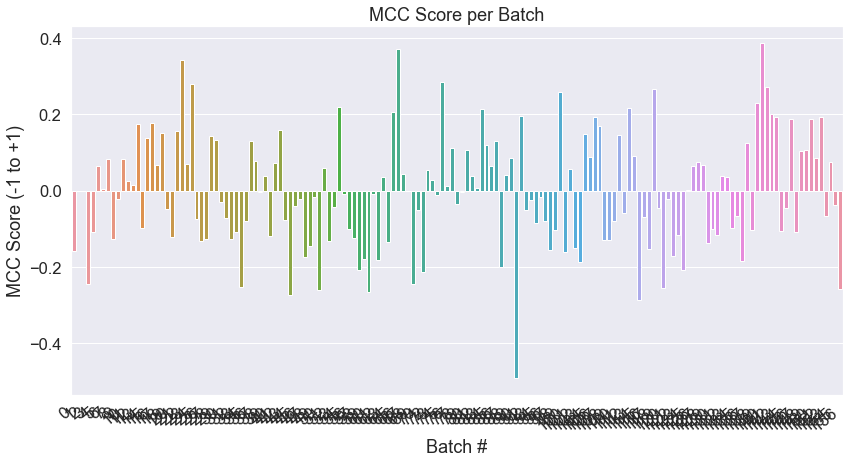

In [93]:
# Create a barplot showing the MCC score for each batch of test samples.

import seaborn as sns
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


plt.tight_layout()
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

In [86]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_vals, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.001


In [38]:
def evaluate(model, val_dl):
    model.eval()
    val_loss = 0
    predictions, true_vals = [], []
    for batch in tqdm(val_dl):
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        val_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    val_loss_avg = val_loss/len(val_dl)
    prediction = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return val_loss_avg, predictions, true_vals

In [39]:
!mkdir Models

In [43]:
def fit(model, epochs, train_dl, val_dl, optimizer):
    for epoch in range(epochs):
        model.train()
        training_loss = 0
        tqdm_progress = tqdm(
            train_dl,
            desc=f'Epoch {epoch+1}',
            leave=False,
            disable=False
            )
        for batch in tqdm_progress:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids' : batch[0],
                'attention_mask' : batch[1],
                'labels' : batch[2]
            }
            outputs = model(**inputs)
            loss = outputs[0]
            training_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            tqdm_progress.set_postfix({'training_loss': f'{loss.item()/len(batch):.3f}'})
        
        torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
        tqdm.write(f'Epoch {epoch}')
        training_loss_avg = training_loss/len(train_dl)
        tqdm.write(f'Training Loss: {training_loss_avg}')

        val_loss, val_preds, val_true = evaluate(model, val_dl)
        val_preds = np.vstack(np.array(val_preds))
        val_f1 = f1_score_func(val_preds, val_true)
        tqdm.write(f'Val Loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')

In [44]:
fit(model, EPOCHS, train_dl, val_dl, optim)

  0%|          | 0/15 [00:00<?, ?it/s]                                        

Epoch 0
Training Loss: 0.8412546463310718


Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.7327196756998698
F1 Score (weighted): 0.7029652900691704


  0%|          | 0/15 [00:00<?, ?it/s]                                          

Epoch 1
Training Loss: 0.5767748348414898


Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.523770926396052
F1 Score (weighted): 0.8425171404864841


  0%|          | 0/15 [00:00<?, ?it/s]                                         

Epoch 2
Training Loss: 0.4126587310805917


Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.3175016118834416
F1 Score (weighted): 0.8882272960683701


  0%|          | 0/15 [00:00<?, ?it/s]                                         

Epoch 3
Training Loss: 0.2992943444289267


Epoch 5:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.3804077486197154
F1 Score (weighted): 0.8761306939070062


  0%|          | 0/15 [00:00<?, ?it/s]                                         

Epoch 4
Training Loss: 0.2252683797851205


Epoch 6:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.28549180378516514
F1 Score (weighted): 0.9148398836304942


  0%|          | 0/15 [00:00<?, ?it/s]                                        

Epoch 5
Training Loss: 0.17654089415445923


Epoch 7:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.2674065591146549
F1 Score (weighted): 0.9080754364627016


  0%|          | 0/15 [00:00<?, ?it/s]                                       

Epoch 6
Training Loss: 0.12879519644193352


Epoch 8:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.24745209577182928
F1 Score (weighted): 0.9282608108116945


  0%|          | 0/15 [00:00<?, ?it/s]                                        

Epoch 7
Training Loss: 0.10068791122175753


Epoch 9:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.26045269121726355
F1 Score (weighted): 0.917608355040572


  0%|          | 0/15 [00:00<?, ?it/s]                                         

Epoch 8
Training Loss: 0.08625127605628222


Epoch 10:   0%|          | 0/80 [00:00<?, ?it/s]

Val Loss: 0.26640767020483813
F1 Score (weighted): 0.924273486257531


  0%|          | 0/15 [00:00<?, ?it/s]                                          

Epoch 9
Training Loss: 0.07630580805707723


100%|██████████| 15/15 [03:44<00:00, 14.98s/it]

Val Loss: 0.2612705962111553
F1 Score (weighted): 0.9240964038729145


In [47]:

_, predictions, true_vals = evaluate(model, val_dl)

100%|██████████| 15/15 [03:35<00:00, 14.37s/it]


In [48]:
print_acc_per_class(np.vstack(predictions), true_vals)

Class: Pos
Accuracy: 69/84
Class: Neg
Accuracy: 77/85
Class: Neu
Accuracy: 269/280


In [4]:
list_df = [{'answer': 'Princess Arya Stark',
  'question': 'Who is the third child and second daughter of Lord Eddard Stark and his wife, Lady Catelyn Stark?'},
 {'answer': 'Westerosi monarchs',
  'question': 'Who is Princess Arya the sister of?'}]


for dic in list_df:
    for key in dic:
        if key == 'answer':
            print(dic[key])
        

Princess Arya Stark
Westerosi monarchs
